# Ishigami function example

In [1]:
import numpy as np
import tensorflow as tf
from bayesmodels import BGPModel
import tensorflow_probability as tfp
import math 
from pyDOE import lhs
from tensorflow_probability.python import distributions  as tfd
import datetime

In [2]:
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.3.0


In [3]:
!ls

G-function.ipynb	Simple_example.ipynb  ishigami2.ipynb
Polynomial_model.ipynb	ishigami1.ipynb


In [4]:
def ishigami(X, a, b):
    return np.sin(X[:,0]) + a*(np.sin(X[:,1])**2) + b*(X[:,2]**4)*np.sin(X[:,0])
    

In [5]:
# Generating input and output training data
a_test= 0.75
b_test= 0.16

Xtrain = (math.pi)*(2*lhs(3, 700)-1.0)
print(Xtrain.shape)

Ytrain = ishigami(Xtrain, a_test, b_test)
print(Ytrain.shape)

(700, 3)
(700,)


## Fitting a Gaussian process

In [6]:
noise_level = 5e-4
kernel_type = 'Matern52'

model = BGPModel(inputs = Xtrain, outputs = Ytrain,
                kernel_type= kernel_type, noise_level = noise_level)

In [7]:
print(model.hypnames_list)

['bgp_model/kernel/beta', 'bgp_model/kernel/vark', 'bgp_model/loc']


In [8]:
new_vark_prior = tfd.Gamma(concentration = 15.0, rate = 15.0)
new_loc_prior = tfd.Normal(loc = 0.0, scale = 0.1,)
model.update_prior('bgp_model/kernel/vark', new_vark_prior)
model.update_prior('bgp_model/loc', new_loc_prior)

In [9]:
mcmc_samples = 6000
num_burnin_steps = 4000
num_adaptation_steps = 3000
adaption_rate = 0.40
init_step_size = [0.05*tf.ones(3), 0.10,0.02]
num_leapfrog_steps = 3
thinning = 2

model.run_mcmc(mcmc_samples, num_burnin_steps,
                     num_adaptation_steps,
                     adaption_rate,
                    init_step_size,
                    num_leapfrog_steps,
                    thinning)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Average acceptance ratio:  0.6444559


In [10]:
import matplotlib.pyplot as plt

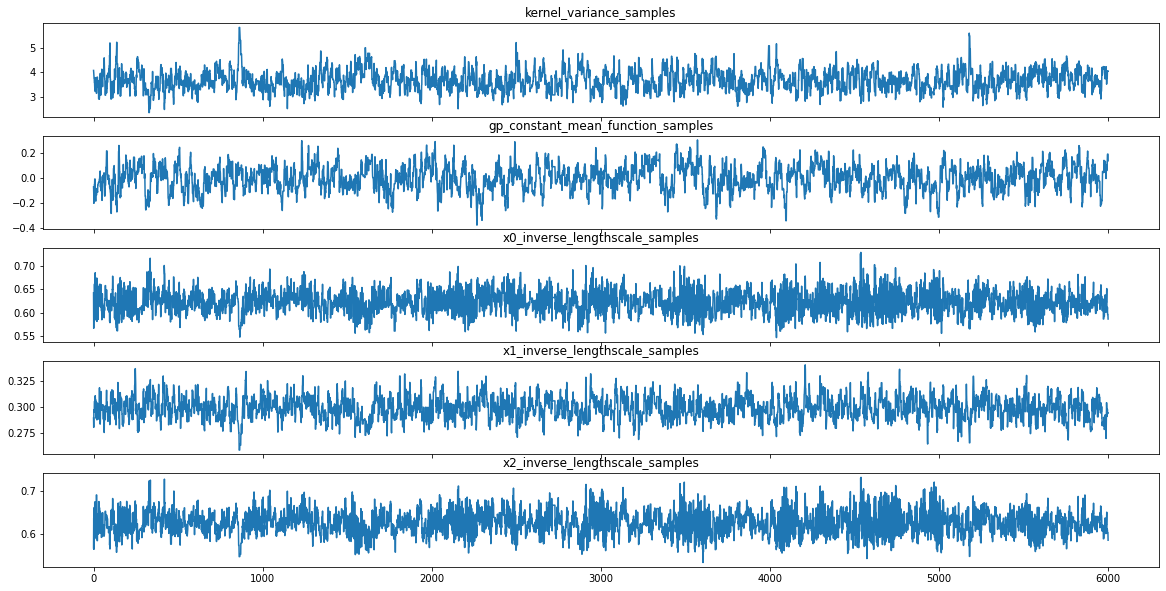

In [11]:
model.plot_chains(display = True, save_plot = False, directory_path = None)

## Sensitivity analysis 

In [12]:
# Theoretical values
def get_true_sobol(a, b):
    
    D = a**2/8 + b*(math.pi**4)/5 + (b**2)*(math.pi**8)/18 + 1/2
    D0 = b*(math.pi**4)/5 + (b**2)*(math.pi**8)/50 + 1/2
    D1 = a**2/8 
    D2 = 0 
    D01 = 0
    D12 = 0 
    D02 = 8*(b**2)*(math.pi**8)/225
    sobol ={}
    sobol['x0'] = D0/D
    sobol['x1'] = D1/D
    sobol['x2'] = D2/D
    sobol['x0 || x1'] = D01/D
    sobol['x1 || x2'] = D12/D
    sobol['x0 || x2'] = D02/D
    
    return sobol

In [13]:
sobol_true = get_true_sobol(a_test, b_test)
print(sobol_true)

{'x0': 0.49325565258798043, 'x1': 0.004092170233993673, 'x2': 0.0, 'x0 || x1': 0.0, 'x1 || x2': 0.0, 'x0 || x2': 0.5026521771780259}


In [15]:
nx_samples = 6000

In [16]:
model.execute_sobol_main_comp()

Number of Sobol computations desired:  6
Actual mumber of Sobol computations to be executed:  6


In [17]:
model.get_Sobol_indices()

{'x0': 0.48677805066108704,
 'x1': 0.005110070575028658,
 'x2': 0.002235955558717251,
 'x0 || x1': 0.0,
 'x0 || x2': 0.46206381265074015,
 'x1 || x2': 0.0}